# Now just using DF directly
## no longer need to parse separately into lists etc.  all done internally
## TO Do the dump load and initialize the DB, need to make sure correct order pf tables is loaded first those with no dependencies and then increasingly so.
## now only erroring on original 3 .txt noted by Ian Gorton in original commnication
- - 1. Conf
- - 2. Pub , Keys, Authors, Affiliations (use sets to create unique ones but may change to all .unique)
- - 3. Composites (Many to Many)
- - 4. Paper/abstracts



In [1]:
import sqlite3
import pandas as pd

In [2]:
import sqlcommands as cmd
cmd = reload(cmd)

(1548, 7)
(1548, 7)


In [ ]:
df = cmd.createTOTALTable()
df.iloc[50:60]

In [ ]:
#don't need 
#df1 = cmd.getPatentDataFrame(hdffile='../DataBaseParsing/DFstore4.h5') 

In [ ]:
df.iloc[0]['Author affiliation']

# Create the Conf Table

In [ ]:
confDF = cmd.createConfTable(df)

In [ ]:
confDF.head()

# Create publications Table
## Now can parse all the orginal .txt with exception of the same 3  Ian gorton noted were errant

In [ ]:
pubDF = cmd.createPublicationsTable(df)

In [ ]:
pubDF.head()
#pubDF.to_csv('Tables_v1/publications.csv', sheet_name = 'publications')

# Create Keys Table

## There are errors here and I have spent way to ong trying to figure if out.  
## Somewhere the abstracts are being split into the terms.

In [ ]:
keys = cmd.createKEYSTable(df)

In [ ]:
print len(keys)
print len(keys.keyword.unique())
keys.iloc[50:75]
keys.head(20)

# Authors
## I don't know how to parse them better!  Each text file seems to look at them differently and no idea what to do

In [ ]:
authorsDF = cmd.createAUTHORSTable(df)

In [ ]:
print len(authorsDF.authorName.drop_duplicates())  #<<--- double check!  will keep one 'empty ' ' becuase of set)
authorsDF.head()

# Affiliation Table
## simple no extra parsing do to differences between entries

In [ ]:
affilDF= cmd.createAFFILIATIONTable(df)

In [ ]:
affilDF.head()
#affilDF.to_csv('Tables_v1/affiliations.csv', sheet_name = 'affilations')

# PAPER TABLE
## should this actually be made by first doing a join or something with the pub table?

In [ ]:
paperDF= cmd.createPAPERTable(df)

In [ ]:
paperDF.iloc[0].terms

In [ ]:
mydb = 'Abstracts_DB.db'
#paperDF.to_csv('Tables_v1/paper.csv', sheet_name = 'paper')
paperDFbyYrandConf = paperDF[['pubYear', 'confName', 'paperID']].groupby(['pubYear', 'confName'], axis = 0)
#paperDFbyYrandConf.count().to_html()
paperDFbyYrandConf.get_group((2007, 'ECSA'))

In [ ]:
def getPapersConfYr(yr, conf):
    with sqlite3.connect(mydb) as con:
        sqlcmd = "SELECT pubYear, confName, paperID, title, abstract FROM PAPER"
        PAPdf = pd.read_sql_query(sqlcmd, con)
    
        group = PAPdf.groupby(['pubYear', 'confName'], axis = 0)
        subgrp = group.get_group((yr, conf))
        
        return subgrp

In [ ]:
y = getPapersConfYr(2004, 'WICSA')
y.index

In [ ]:
mytable = []
for idx in y.index.get_values():
    entry = {}
    entry['paperID'] = y.loc[idx]['paperID']
    entry['title'] = y.loc[idx]['title']
    entry['abstract'] = y.loc[idx]['abstract']
    mytable.append(entry)
x = dict(data = mytable)
    

In [ ]:
x

# PAPERKEY COMPOSITE

In [ ]:
pk = cmd.createPAPERKEYTable(paperDF)

In [ ]:
pk.head()

In [ ]:
pk.tail()

In [ ]:
paperKey = pk.merge(paperDF[['paperID', 'title','confName', 'pubYear']], on = 'paperID')
paperKey.head()

In [130]:
def getPapersKWgroup(grouper):
    with sqlite3.connect('Abstracts_DB.db') as con:
        sqlcmd = "SELECT paperID, title, confName, pubYear FROM PAPER "
        
        paperdf = pd.read_sql_query(sqlcmd, con)
        
        sqlcmd2 = "SELECT paperID, keyword FROM PAPERKEY "
        kwdf = pd.read_sql_query(sqlcmd2, con)
        kwdf['keyword'] = kwdf['keyword'].apply(lambda word: eval(word))
        
        merged = kwdf.merge(paperdf, on = 'paperID')
        
        subgrp = merged.groupby(grouper)
        
        return merged, subgrp

In [4]:
def getKWTrend(keyword):
    paperFreq = getPapersKWgroup('keyword')
    
    #paperFreq['keyword'] = paperFreq['keyword'].apply(lambda word: eval(word))
    
    return paperFreq


In [ ]:
paperKeyword = paperKey.groupby('paperID').count()
paperKwYr = paperKey.groupby('pubYear')

In [ ]:
paperKwYr.get_group(2010)[['paperID', 'keyword']].groupby('keyword').count().sort('paperID', ascending = False)  

In [ ]:
#KeywordFreq[:50].plot(kind = 'bar', x = 'keyword', y = 'paperID')
##broken down by conferences and years...  (enter a keyword and see trend over conference and year.

##top keywords(cts?) for given conference over the years.

##compare the confernces - given two conferences display their top keywords for a given year

##do same for authors and what conferences.

##top 20 authors and their keywords, conferences, trends over time.


In [ ]:
#enter a keyword and see trend over conference and year.
try1 = paperKey
try1 = try1.groupby('keyword')

In [ ]:
paperFreq, merged = getPapersKWgroup('keyword')

In [ ]:
overallbreakdown = paperFreq.count()
overallbreakdown.reset_index(inplace = True)
overallbreakdown.head()

In [118]:
#import matplotlib as plt
%matplotlib inline
def confYrKeywords(top = 10):
    grouper = ['confName', 'pubYear']
    m, f = getPapersKWgroup(grouper)
    myentries = []
    for group in f.groups.keys():
        print group
        keywordcts = f.get_group((group)).groupby(["keyword"])["keyword"].count()
        
        kwdftop = keywordcts.sort_values(ascending = False).head(top)
        
        resetKW = pd.DataFrame(kwdftop).rename(columns = {'keyword' : 'count'})
        entry = {}
        entry['Group'] = group
        
        entry['Pie'] = getPieOne(resetKW, group)
        entry['Counts'] = resetKW.to_html()
        
        myentries.append(entry)
    
    return dict(data = myentries)
        
        
        

In [105]:

keywordcts = f.get_group(('ECSA', 2007)).groupby(["keyword"])["keyword"].count()

top10 = keywordcts.sort_values(ascending = False)
top10.head()

keyword
Computer Applications              36
Computer Programming               33
Software engineering techniques    32
software architecture              31
Formal methods                     11
Name: keyword, dtype: int64

NameError: name 'tail' is not defined

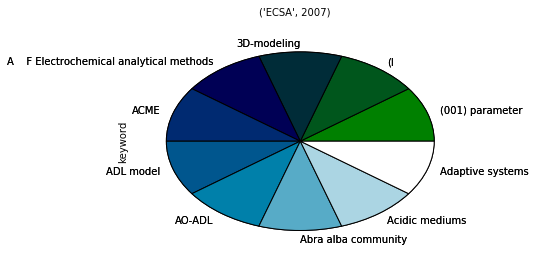

In [122]:

keywordcts.head(10).plot(kind = 'pie')
getPieOne(keywordcts.head(10), ('ECSA', 2007) )
kwdf = keywordcts.head(10)
new = pd.DataFrame(kwdf).rename(columns = {'keyword' : 'count'})
new
getPieOne(new, ('ECSA', 2007))
getBar(new, ('ECSA', 2007))

(u'WICSA', 2004)
(u'WICSA', 2011)
(u'ECSA', 2008)
(u'QoSA', 2012)
(u'QoSA', 2005)
(u'WICSA', 2012)
(u'QoSA', 2008)
(u'ECSA', 2013)
(u'WICSA', 2005)
(u'WICSA', 2008)
(u'ECSA', 2009)
(u'QoSA', 2013)
(u'QoSA', 2006)
(u'QoSA', 2009)
(u'ECSA', 2014)
(u'ECSA', 2007)
(u'WICSA', 2009)
(u'ECSA', 2010)
(u'QoSA', 2014)
(u'QoSA', 2007)
(u'QoSA', 2010)


/Users/aileennovero1/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(u'WICSA', 2014)
(u'ECSA', 2011)
(u'WICSA', 2007)
(u'QoSA', 2011)
(u'ECSA', 2012)


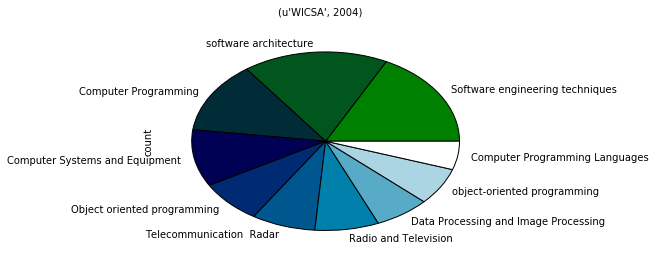

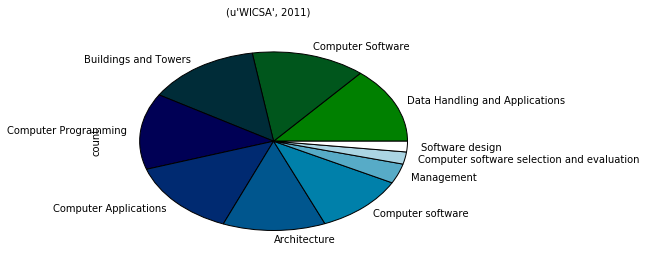

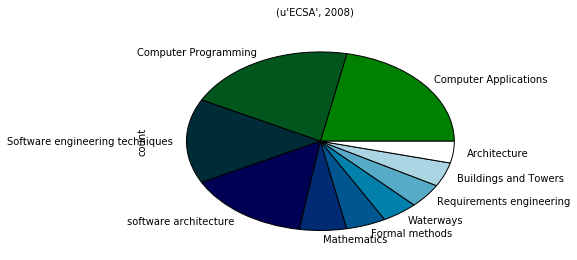

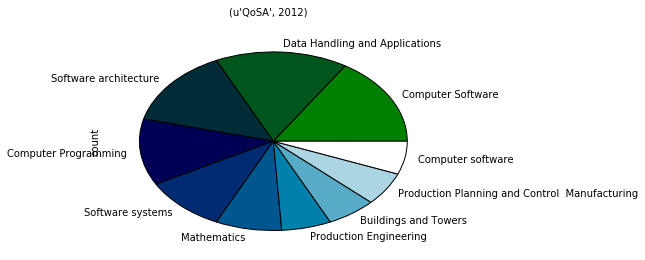

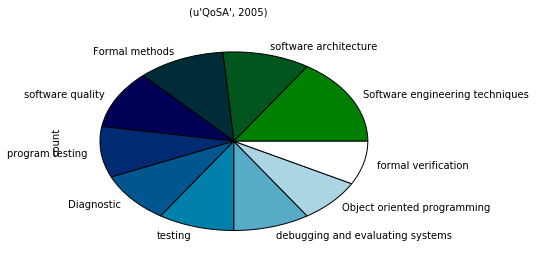

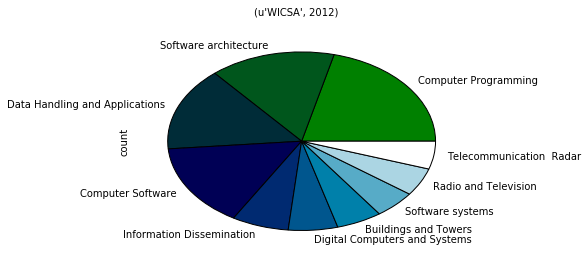

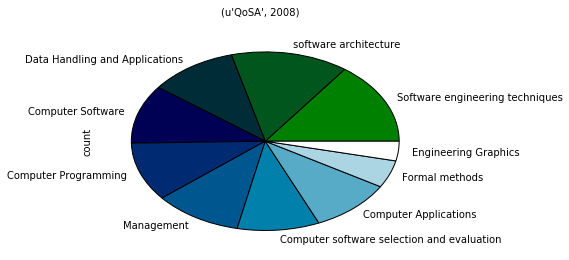

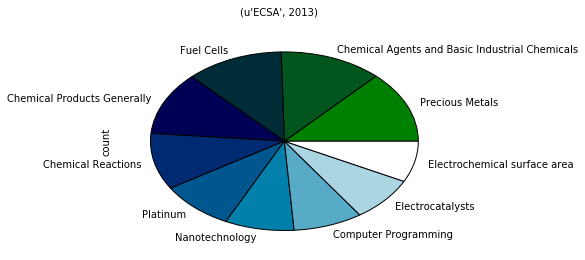

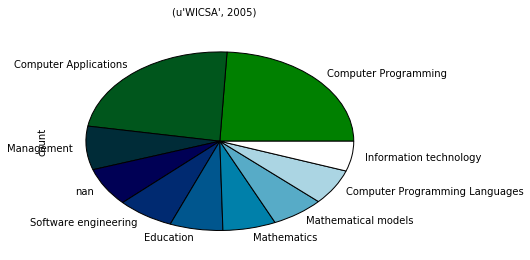

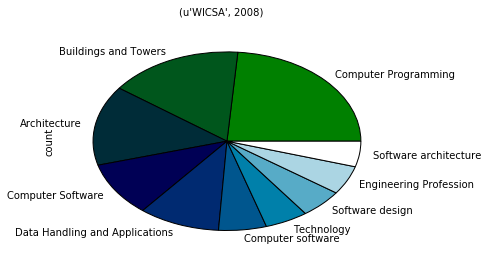

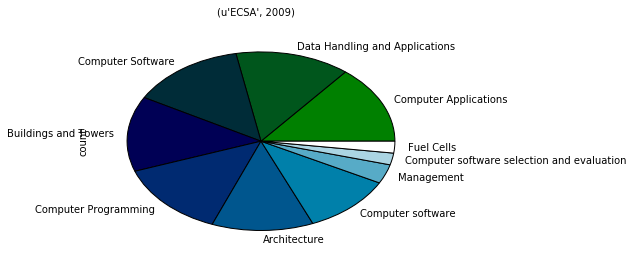

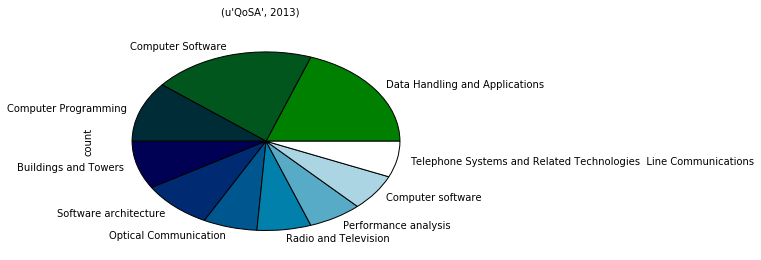

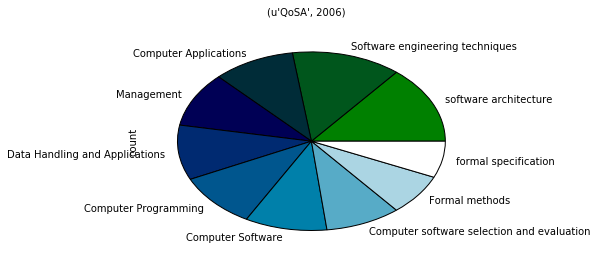

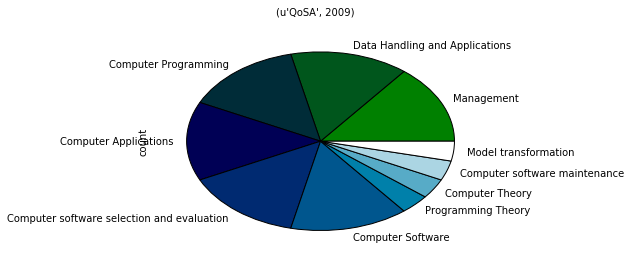

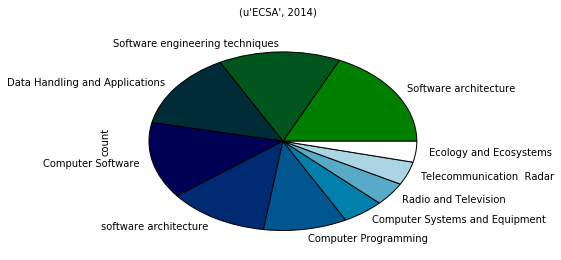

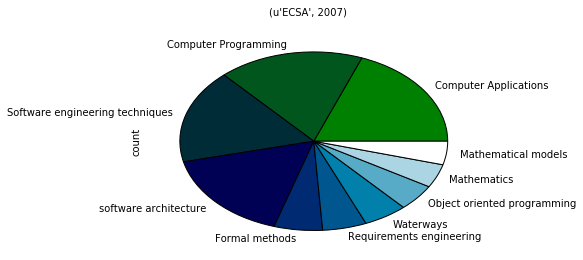

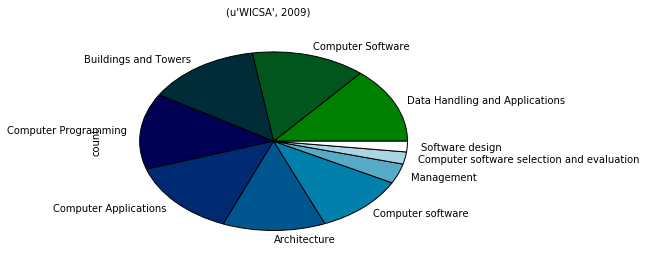

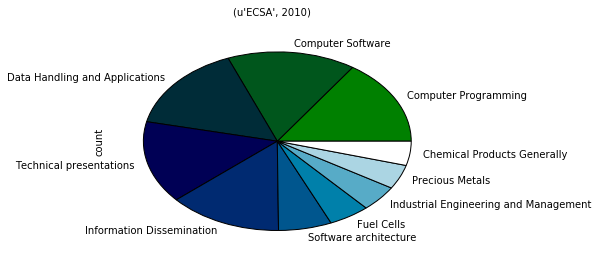

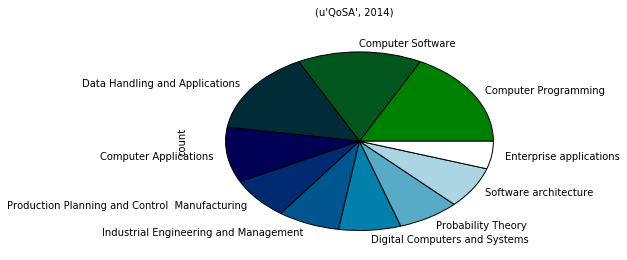

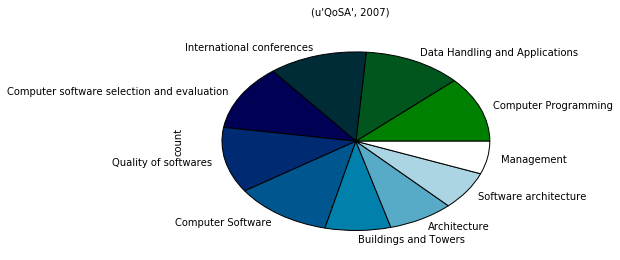

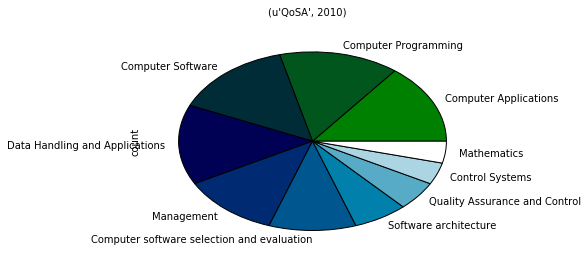

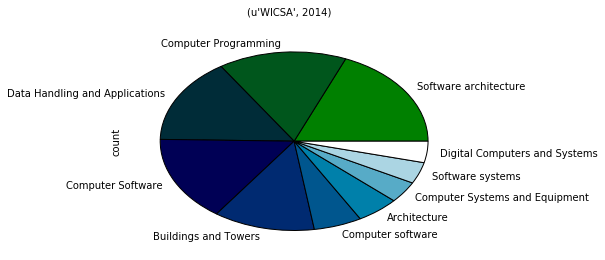

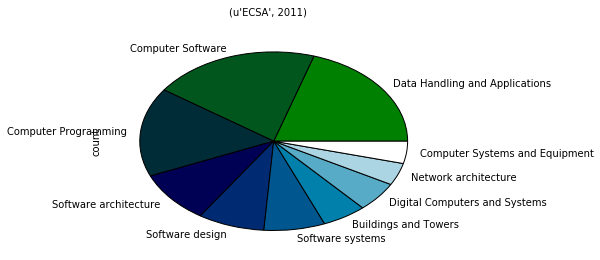

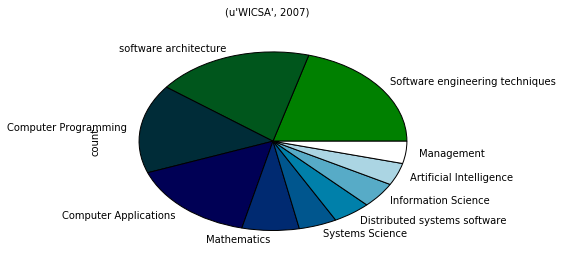

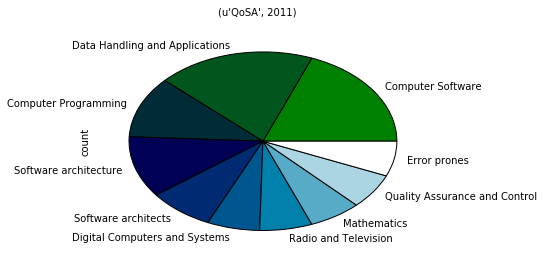

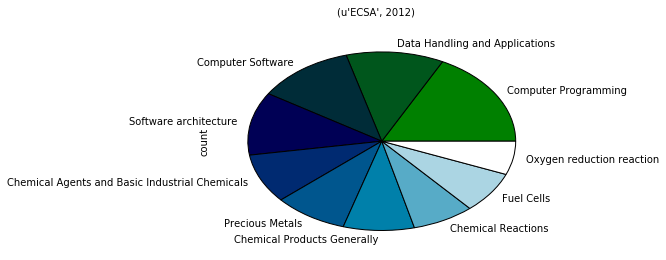

In [119]:
tryit = confYrKeywords()



In [89]:
tryit

<function __main__.confYrKeywords>

In [249]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cStringIO import StringIO
import base64
import seaborn as sns
%matplotlib inline

def getPieOne(df, conference):
    fig = plt.figure()
    fig = df.plot(kind = 'pie', colormap = 'Blues', title = conference, subplots = True, legend = False, labels = ['' for x in np.arange(len(df))])
    plt.ylabel('')
    
    plt.legend( list(df.index),  bbox_to_anchor=(1.1, 1),
              fontsize = "xx-small")
    io = StringIO()
    plt.savefig(io, format='png')
    img = base64.encodestring(io.getvalue())
   
    io = StringIO()
    plt.savefig(io, format='png')
    data = base64.encodestring(io.getvalue())
    script = '''<img src="data:image/png;base64,{}";/>'''
    return fig

def getBar(df, conference):
    plt.figure()
    ax =  df.plot(kind = 'bar', colormap = 'ocean', title = conference, subplots = True,legend = False)
   
    io = StringIO()
    plt.savefig(io, format='png')
    img = base64.encodestring(io.getvalue())
   
    io = StringIO()
    plt.savefig(io, format='png')
    data = base64.encodestring(io.getvalue())
    script = '''<img src="data:image/png;base64,{}";/>'''
    
def getBarKW(df, conference):
    
    fig = sns.barplot(data = new, y = 'keyword', x = 'count', palette='Blues', orient = 'h')
   
    io = StringIO()
    plt.savefig(io, format='png')
    img = base64.encodestring(io.getvalue())
   
    io = StringIO()
    plt.savefig(io, format='png')
    data = base64.encodestring(io.getvalue())
    script = '''<img src="data:image/png;base64,{}";/>'''
    return fig

def getHeatMap(data_frame, indexCol = 'confName', cols = 'pubYear', vals = 'counts'):
    
    fig = sns.heatmap(data_frame.pivot_table(index=indexCol, 
                                             columns=cols, 
                                             values=vals),
                                             cmap = 'Blues')
    
    io = StringIO()
    plt.savefig(io, format='png')
    img = base64.encodestring(io.getvalue())
   
    io = StringIO()
    plt.savefig(io, format='png')
    data = base64.encodestring(io.getvalue())
    script = '''<img src="data:image/png;base64,{}";/>'''
    return fig

def getLine(data_frame, xaxis = 'confName', yaxis = 'counts'):
    plt.cla()
    fig = sns.swarmplot(data = data_frame, x=xaxis, y = yaxis,palette = 'Blues')
    
    io = StringIO()
    plt.savefig(io, format='png')
    img = base64.encodestring(io.getvalue())
   
    io = StringIO()
    plt.savefig(io, format='png')
    data = base64.encodestring(io.getvalue())
    script = '''<img src="data:image/png;base64,{}";/>'''
    return fig

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12886efd0>], dtype=object)

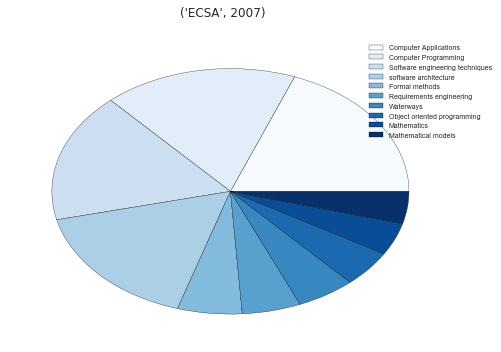

In [304]:

kwdf = keywordcts.sort_values(ascending = False)


new = pd.DataFrame(kwdf.head(10)).rename(columns = {'keyword' : 'count'})
f = getPieOne(new, ('ECSA', 2007) )
new.reset_index(inplace = True)
new
f

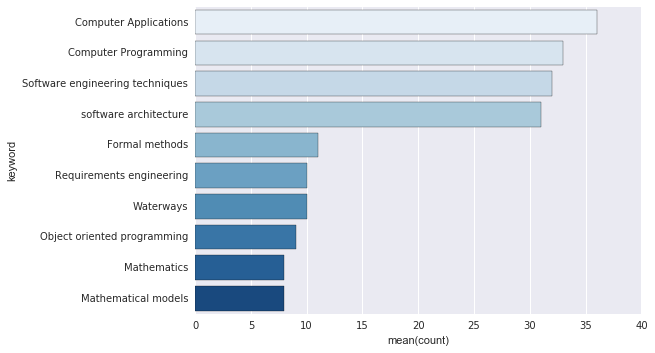

In [361]:
ax = plt.figure()
ax = sns.barplot(data = new, orient = "h", x = 'count', y = 'keyword', palette='Blues')




In [35]:
table = []
for idx in cts.index.get_values():
    entry = {}
    kw = cts.iloc[idx].keyword
    entry['kw'] = cts.iloc[idx].keyword
    entry['counts'] = cts.iloc[idx].counts
    mygroup = f.get_group(kw)
    entry['papers'] = list(mygroup.paperID)
    entry['conferences'] = list(mygroup.confName)
    entry['years'] = list(mygroup.pubYear)
    table.append(entry)

In [24]:
pd.DataFrame(table).head()

,conferences,count,kw,papers,years
0,"[ECSA, ECSA]",2,(001) parameter,"[351, 352]","[2007, 2008]"
1,"[ECSA, ECSA]",2,(I,"[768, 769]","[2007, 2008]"
2,[QoSA],1,.NET,[833],[2008]
3,"[ECSA, ECSA]",2,1,"[43, 1435]","[2013, 2012]"
4,[ECSA],1,2-hop neighbourhood,[1160],[2010]


In [117]:
m= getPapersKWgroup2()
m.head()

,paperID,keyword,title,confName,pubYear
0,1,Research challenges,On the need of safe software product line arch...,ECSA,2010
1,1,Software product line architecture,On the need of safe software product line arch...,ECSA,2010
2,1,Materials Science,On the need of safe software product line arch...,ECSA,2010
3,1,Structural properties,On the need of safe software product line arch...,ECSA,2010
4,1,Software product lines,On the need of safe software product line arch...,ECSA,2010


In [128]:
m.head()

,paperID,keyword,title,confName,pubYear
0,1,Research challenges,On the need of safe software product line arch...,ECSA,2010
1,1,Software product line architecture,On the need of safe software product line arch...,ECSA,2010
2,1,Materials Science,On the need of safe software product line arch...,ECSA,2010
3,1,Structural properties,On the need of safe software product line arch...,ECSA,2010
4,1,Software product lines,On the need of safe software product line arch...,ECSA,2010


In [252]:
def getKWTRends(kw, grouper):
    
    m, f = getPapersKWgroup(grouper)
    
    query2 = '"%s" == keyword' %kw
    
    data_frame = m.copy()
    data_frame.query(query2, inplace = True)
    new = data_frame.copy()
    
    def findKWTrend(df, KWgrouper = ["pubYear", "confName"]):
        labels = {'ECSA' : 0,
                  'QoSA' : 1,
                  'WICSA' : 2}
        df = df.groupby(KWgrouper)['keyword'].count().reset_index(name="counts")
        df['confCode'] = df.confName.apply(lambda name: labels[name])
        try:
            return getHeatMap(df)
        except:
            return 'no data'
        
    
    image = findKWTrend(new)
    
    myentry = [{'table' : data_frame.to_html(),
              'trend'  : image
               }]
    
    return dict(data = myentry)

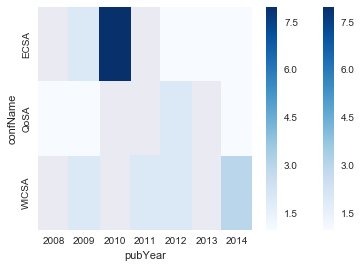

In [260]:
t = getKWTRends('Research', 'keyword')
t = getKWTRends('Research', 'keyword')

In [222]:
new = t.groupby(["pubYear", "confName"])['keyword'].count().reset_index(name="counts")
labels = {'ECSA' : 0,
         'QoSA' : 1,
         'WICSA' : 2}
new['confCode'] = new.confName.apply(lambda name: labels[name])
new.head()

,pubYear,confName,counts,confCode
0,2010,ECSA,7,0
1,2011,ECSA,2,0
2,2012,ECSA,1,0
3,2012,WICSA,1,2
4,2013,ECSA,3,0


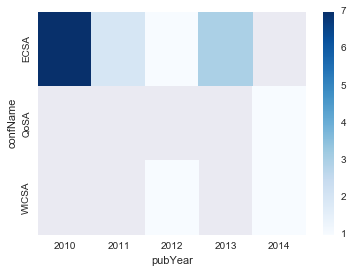

In [223]:
#sns.heatmap(new.pivot_table( index='confName', columns='pubYear', values='counts'), cmap = 'Blues')
getHeatMap(new)

# Affiliation_Paper Composite 
## necessary?

In [224]:
ctsmerge.head()

NameError: name 'ctsmerge' is not defined

In [104]:
def getPaperKW():
    m, data_frame = getPapersKWgroup('paperID')
    entries = []
    for each in data_frame.groups:
        entry = {}
        entry['paperID'] = each
        entry['keywords'] = [key for key in data_frame.get_group(each)['keyword']]
        
        entries.append(entry)
    return dict(data = entries)

In [105]:
j = getPaperKW()

In [106]:
j

{'data': [{'keywords': [u'Research challenges',
    u'Software product line architecture',
    u'Materials Science',
    u'Structural properties',
    u'Software product lines',
    u'Software systems',
    u'Software design',
    u'Product-lines',
    u'Computer Programming',
    u'Feature models',
    u'Structural Design'],
   'paperID': 1},
  {'keywords': [u'Model transformation',
    u'Design complexity',
    u'Computer software',
    u'Architectural decision',
    u'Data Handling and Applications',
    u'Product architecture',
    u'Computer Systems and Equipment',
    u'Software product lines',
    u'Computer Programming',
    u'Feature models',
    u'Application engineering',
    u'Computer Software',
    u'Domain knowledge',
    u'Computer Applications',
    u'Buildings and Towers',
    u'Software Product Line',
    u'Architecture',
    u'Model-driven Engineering',
    u'Meshing tools',
    u'Domain engineering',
    u'Software design',
    u'Evolvability',
    u'Product line a

In [98]:
def search_kw(kw):
    print "kw", kw
    
    
    m, f = getPapersKWgroup('keyword')
    cts = m.groupby(["keyword"])["keyword"].count().reset_index(name="counts")
    ctsmerge = cts.merge(m, on = 'keyword').groupby('keyword')   
    
    try:
        print kw
        subgroup = ctsmerge.get_group(kw)
        mytable = []
            
        for idx in subgroup.index.get_values():
            print idx
            entry = {}
            entry['paperID'] = subgroup.loc[idx].paperID
            entry['Title'] = subgroup.loc[idx]['title']
            entry['Conference'] = subgroup.loc[idx]['confName']   
            entry['PublicationYear'] = subgroup.loc[idx]['pubYear'] 
            mytable.append(entry)
       
        return dict(data = mytable)
    except:
        print (kw,'subgroupfail')
        entry = {'paperID': 'No Keyword Found',
                     'Title': 'No Keyword Found',
                     'Conference': 'No Keyword Found',
                     'PublicationYear': 'No Keyword Found'
                     }
        mytable = [entry]
        return dict(data = mytable)


kw =     'aspectual concept'

In [96]:
kw2 = 'wireless sensor networks'

1461

In [101]:
search_kw(u'vulnerability')


kw vulnerability
vulnerability
25658
25659


{'data': [{'Conference': u'ECSA',
   'PublicationYear': 2012,
   'Title': u'SecArch  Architecture level evaluation and testing for security',
   'paperID': 1417},
  {'Conference': u'WICSA',
   'PublicationYear': 2012,
   'Title': u'SecArch  Architecture level evaluation and testing for security',
   'paperID': 1418}]}

In [ ]:
paperAffiliationDF = cmd.createAFFILIATIONPAPERTable(paperDF, affilDF)

In [ ]:
paperAffiliationDF.tail()
#paperAffiliationDF.to_csv('Tables_v1/paperAffiliation.csv', sheet_name = 'paperAffil')

In [ ]:
paperDF[['paperID', 'pubYear']].merge(paperAffiliationDF, on = 'paperID').tail()

# PAPERAUTHORS COMPOSITE

In [ ]:
authorPaper = cmd.createPAPERAUTHORTable(paperDF[['paperID', 'authors']])
#authorPaper.to_csv('Tables_v1/authorPaper.csv', sheet_name = 'paperAuthor')

In [ ]:
authorPaper.head(20)

In [ ]:
paperDF[['paperID', 'title']].merge(authorPaper, on = 'paperID').head(20)

In [ ]:
from flask import *

In [ ]:
confDF.to_html()

In [ ]:
confDF.plot(kind = 'box')

In [ ]:
%matplotlib inline

Queries:
As for the given queries: 
papers with key word grouped by year.   
- PaperID ---> KeywordFK, PaperID --> PublicationID:year

author's most buzzy words : 
- authorID ---> paperID -->KeyWordId (count) (sort).max

paper's affiliation grouped by conference and year  ??
- paper ID:affiliation ---> publicationID:year -->ConferenceID:type

conference/year and the keywords in order of frequency (ie word cloud visualization maybe?)  <<_--this might break it?
- confID -->publicationID --> PaperIDs-->KeywordIDs (count) (sort descending)

Affiliation's authors
- authorsID--: papersIds: affiliation  (i need to check if an author can have multiple affiliations, I can't see why not if they change universities or companies after 10 years)


Most frequent affiliations per conference
paperIDs: affiliation --> publicationIDs --> ConferenceID

In [ ]:
q1 = pk.merge(paperDF[['paperID', 'pubYear']], on = 'paperID')


In [ ]:
len(q1['keyword'].unique())

In [ ]:
len(authorPaper)

In [ ]:
authorAffiliation = authorPaper.merge(paperDF[['paperID', 'affiliation', 'pubYear']])

In [ ]:
authorAffiliation.query('"Muccini, Henry" in authorName').sort('pubYear')

In [ ]:
#paper's affiliation grouped by conference and year ??
papafiil = paperAffiliationDF.merge(paperDF[['paperID', 'pubYear', 'confName']], on = 'paperID')

In [ ]:
groupPA = papafiil.groupby(['pubYear', 'confName'])

In [ ]:
groupPA.aggregate('count')

In [ ]:
conf